# AIRE
[autoimmune polyendocrinopathy syndrome type I (APS1)](https://omim.org/entry/240300) is caused by homozygous, compound heterozygous, or heterozygous mutation in the autoimmune regulator gene (AIRE).

In [16]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


In [17]:
gene_symbol = 'AIRE'
mane_tx_id = 'NM_000383.4'
mane_protein_id = 'NP_000374.1' # autoimmune regulator

In [18]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

cohort_name = gene_symbol
phenopacket_store_release = '0.1.23'


registry = configure_phenopacket_registry()
cohort_creator = configure_caching_cohort_creator(hpo)
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 58/58 [00:00<00:00, 1026.51individuals/s]
Validated under permissive policy
No errors or warnings were found


In [19]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
56,Hypoparathyroidism
37,Primary adrenal insufficiency
35,Chronic mucocutaneous candidiasis
14,Recurrent fungal infections
13,Decreased circulating parathyroid hormone level
11,Alopecia
8,Antiparietal cell antibody positivity
8,Alopecia universalis
7,Vitiligo
7,Anti-thyroid peroxidase antibody positivity


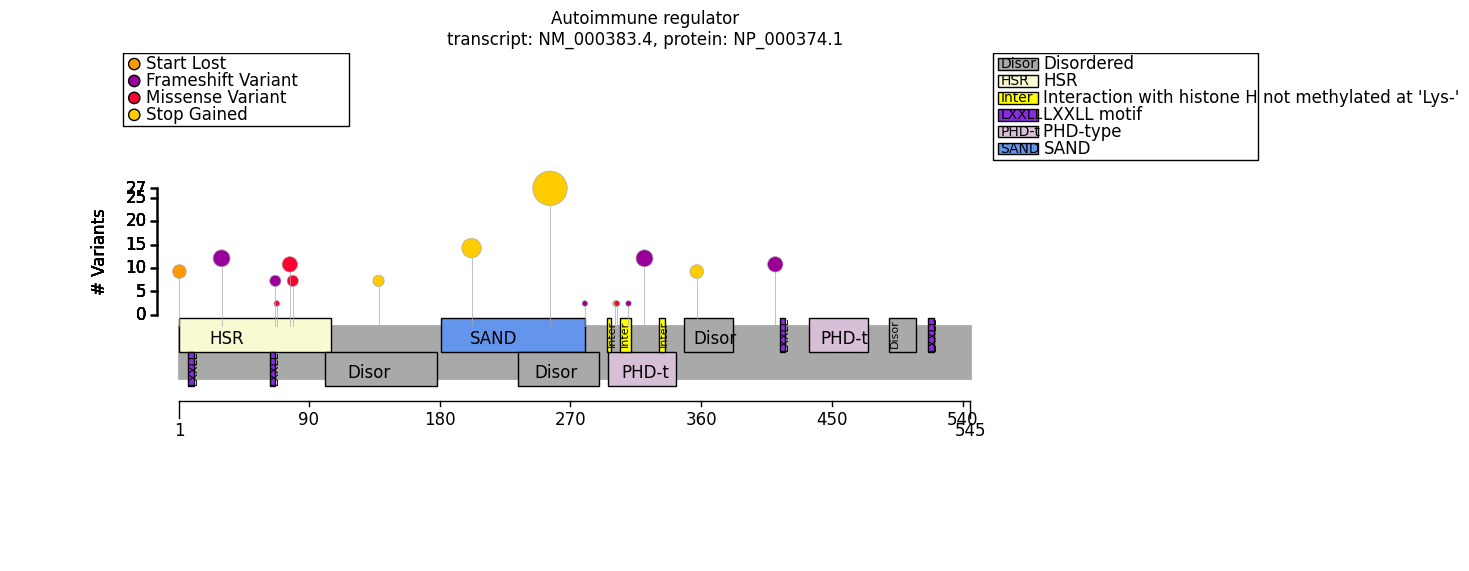

In [20]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
aire_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
aire_fig.tight_layout()

[Halonen et al (2002)](https://pubmed.ncbi.nlm.nih.gov/12050215/) stated that  patients carrying at least one R257X allele, the incidence of Addison’s disease as well as mucocutaneous candidiasis was higher than in the others  (P < 0.001). The authors did not provide row-level data.

In [21]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

# Compare monoallelic and biallelic cases

In [22]:


from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import biallelic_classifier
from gpsea.view import MtcStatsViewer

r257ter = variant_key("21_44289773_44289773_C_T") #c.769C>T	p.Arg257Ter

r357ter_clf = biallelic_classifier(a_predicate=r257ter,
                                        b_predicate=~r257ter,
                                        a_label="R257*",
                                        b_label="other",
                                        partitions=((0,1), (2,)))
r357ter_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r357ter_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(r357ter_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,20
HMF03,Skipping term because of a child term with the same individual counts,3
HMF08,Skipping general term,67
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,87


In [23]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=r357ter_result)

Allele group                                       R257*/R257* OR R257*/other  \
                                                                        Count   
Antiparietal cell antibody positivity [HP:6000343]                        3/5   
Chronic mucocutaneous candidiasis [HP:0002728]                          12/12   
Primary adrenal insufficiency [HP:0008207]                              18/24   
Anti-thyroid peroxidase antibody positivity [HP...                        1/2   
Alopecia [HP:0001596]                                                    7/14   
Hypoparathyroidism [HP:0000829]                                         25/25   
Adrenal insufficiency [HP:0000846]                                      18/18   
Recurrent cutaneous fungal infections [HP:0011370]                      12/12   
Recurrent fungal infections [HP:0002841]                                24/24   
Unusual infection [HP:0032101]                                          24/24   
Recurrent infections [HP:0002719]                                       24/24   
Increased inflammatory response [HP:0012649]                            21/21   

Allele group                                               other/other  \
                                                   Percent       Count   
Antiparietal cell antibody positivity [HP:6000343]     60%        5/24   
Chronic mucocutaneous candidiasis [HP:0002728]        100%       23/28   
Primary adrenal insufficiency [HP:0008207]             75%       18/30   
Anti-thyroid peroxidase antibody positivity [HP...     50%        6/23   
Alopecia [HP:0001596]                                  50%       12/21   
Hypoparathyroidism [HP:0000829]                       100%       28/29   
Adrenal insufficiency [HP:0000846]                    100%       18/18   
Recurrent cutaneous fungal infections [HP:0011370]    100%       23/23   
Recurrent fungal infections [HP:0002841]              100%       23/23   
Unusual infection [HP:0032101]                        100%       23/23   
Recurrent infections [HP:0002719]                     100%       23/23   
Increased inflammatory response [HP:0012649]          100%       23/23   

Allele group                                                                   \
                                                   Percent Corrected p values   
Antiparietal cell antibody positivity [HP:6000343]     21%                1.0   
Chronic mucocutaneous candidiasis [HP:0002728]         82%                1.0   
Primary adrenal insufficiency [HP:0008207]             60%                1.0   
Anti-thyroid peroxidase antibody positivity [HP...     26%                1.0   
Alopecia [HP:0001596]                                  57%                1.0   
Hypoparathyroidism [HP:0000829]                        97%                1.0   
Adrenal insufficiency [HP:0000846]                    100%                1.0   
Recurrent cutaneous fungal infections [HP:0011370]    100%                1.0   
Recurrent fungal infections [HP:0002841]              100%                1.0   
Unusual infection [HP:0032101]                        100%                1.0   
Recurrent infections [HP:0002719]                     100%                1.0   
Increased inflammatory response [HP:0012649]          100%                1.0   

Allele group                                                  
                                                    p values  
Antiparietal cell antibody positivity [HP:6000343]  0.111877  
Chronic mucocutaneous candidiasis [HP:0002728]      0.298009  
Primary adrenal insufficiency [HP:0008207]          0.383959  
Anti-thyroid peroxidase antibody positivity [HP...  0.490000  
Alopecia [HP:0001596]                               0.739107  
Hypoparathyroidism [HP:0000829]                     1.000000  
Adrenal insufficiency [HP:0000846]                  1.000000  
Recurrent cutaneous fungal infections [HP:0011370]  1.000000  
Recurrent fungal infections [HP:0002841]            1.000000  


In [24]:
from gpsea.analysis.temporal.endpoint import hpo_onset
term_id = "HP:0002728"  # Chronic mucocutaneous candidiasis HP:0002728
endpoint = hpo_onset(hpo=hpo, term_id=term_id)
endpoint.description

'Compute time until onset of Chronic mucocutaneous candidiasis'

In [25]:
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
r357t_CMC_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=r357ter_clf,
    endpoint=endpoint,
)

In [26]:
print(f"log-rank p-value for {term_id} and R357*/R357* or R357*/other versus other/other {r357t_CMC_onset_result.pval:.4f}")

log-rank p-value for HP:0002728 and R357*/R357* or R357*/other versus other/other 0.0192


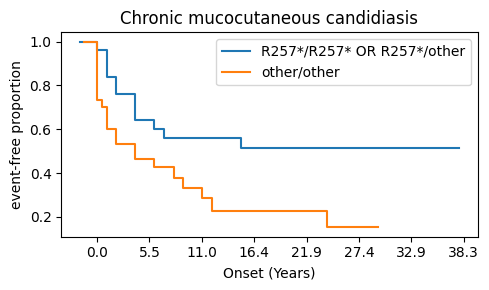

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(5, 3))
r357t_CMC_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Chronic mucocutaneous candidiasis")

plt.tight_layout()
plt.show()

# Summary

In [28]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=r357t_CMC_onset_result,
    ),
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=r357ter_result,
        xrefs={
            term_id: ('PMID:12050215'),
        },
        interpretation="""The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other variants. We did not identify a significant difference in prevalence."""
    ),
)



cohort_name = gene_symbol

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption="The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other variants. We did not identify a significant difference in prevalence"
)

In [29]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [30]:
summarizer.process_latex(report=report, protein_fig=aire_fig)

Figure saved to ../../supplement/img/AIRE_protein_diagram-draft.pdf
Output to ../../supplement/tex/AIRE_summary_draft.tex
